In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [2]:
#url ile dataset indirme
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [3]:
# Arşivden çıkar
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
airplane_dir = os.listdir(data_dir + "/train/airplane")
print("Uçaklar için eğitim örnekleri sayısı:",len(airplane_dir))
airplane_dir[:5]

Uçaklar için eğitim örnekleri sayısı: 5000


['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']

In [6]:
ship_test_dir = os.listdir(data_dir + "/test/ship")
print("Gemiler için test örnekleri sayısı:",len(ship_test_dir))
ship_test_dir[:5]

Gemiler için test örnekleri sayısı: 1000


['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


Yukarıdaki dizin yapısı (sınıf başına bir klasör) birçok bilgisayar görüşü veri kümesi tarafından kullanılır ve çoğu derin öğrenme kitaplığı bu tür veri kümeleriyle çalışmak için faydalar sağlar. Verileri PyTorch tensörleri olarak yüklemek için torchvision'daki ImageFolder sınıfını kullanabiliriz.

Yani png olarak bulunan resimleri tensore çevirmek için

In [7]:
dataset = ImageFolder(data_dir + "/train", transform = ToTensor())

Eğitim veri kümesinden örnek bir öğeye bakalım. Her öğe, bir görüntü tensörü ve bir etiket içeren bir demettir. Veriler, 3 kanallı (RGB) 32x32 piksel renkli görüntülerden oluştuğu için her görüntü tensörü şekle (3, 32, 32) sahiptir.

In [8]:
img, label = dataset[0]
print(img.shape,"Label:",label)
print(img)

torch.Size([3, 32, 32]) Label: 0
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157,

Sınıfların listesi, veri kümesinin .classes özelliğinde saklanır. Her elemanın sayısal etiketi, sınıflar listesindeki elemanın etiketinin dizinine karşılık gelir.

In [9]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']


Görüntüyü matplotlib kullanarak görebiliriz, ancak tensör boyutlarını (32,32,3) olarak değiştirmemiz gerekiyor. Bir görüntüyü ve etiketini görüntülemek için bir yardımcı işlev oluşturalım.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [11]:
img.permute(1, 2, 0).shape#resmi görmek için 32 32 3 halibe getiriyoruz

torch.Size([32, 32, 3])

In [12]:
img.shape

torch.Size([3, 32, 32])

In [13]:
def show_example(img, label):
    print("Label:",dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label: airplane (0)


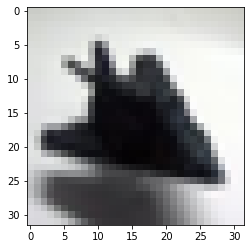

In [14]:
show_example(*dataset[0])

Label: bird (2)


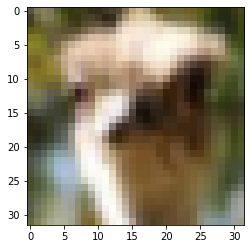

In [15]:
show_example(*dataset[11561])

Önceden tanımlanmış bir doğrulama seti olmadığından, doğrulama seti olarak kullanılmak üzere eğitim setinin küçük bir bölümünü (5000 görüntü) ayırabiliriz. Bunu yapmak için PyTorch'un random_split yardımcı yöntemini kullanacağız. Her zaman aynı doğrulama kümesini oluşturduğumuzdan emin olmak için, rastgele sayı üreteci için de bir çekirdek belirleyeceğiz.

In [16]:
random_seed = 42
torch.manual_seed(random_seed)

In [17]:
val_size = 5000
train_size = len(dataset) - val_size

In [18]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds)

45000

Jovian kitaplığı aynı zamanda veri seti, model eğitimi, sonuçlar vb. İle ilgili önemli parametreleri kaydetmek için basit bir API sağlar ve çoklu deneyler arasında kolay referans ve karşılaştırma sağlar. Jovian.log_dataset kullanarak dataset_url, val_pct ve rand_seed kayıt edelim.

In [19]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(val_ds, batch_size = 2*batch_size, num_workers=4, pin_memory=True)


Torchvision'dan make_grid yöntemini kullanarak veri kümesindeki toplu görüntülere bakabiliriz. Aşağıdaki kod her çalıştırıldığında, örnekleyici gruplar oluşturmadan önce dizinleri karıştırdığından farklı bir beklemeyle karşılaşırız.

In [20]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

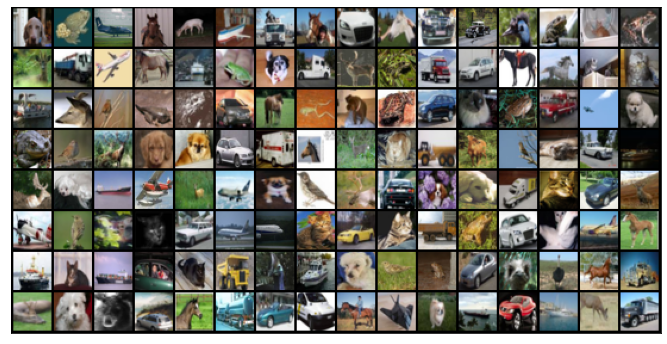

In [21]:
show_batch(train_loader)

## Defining the Model (Convolutional Neural Network)

Önceki eğitimimizde, nn.Linear kullanarak tamamen bağlı katmanlara sahip derin bir sinir ağı tanımladık. Ancak bu eğitim için PyTorch'un nn.Conv2d sınıfını kullanarak evrişimli bir sinir ağı kullanacağız.


2D evrişim özünde oldukça basit bir işlemdir: basitçe küçük bir ağırlık matrisi olan bir çekirdekle başlarsınız. Bu çekirdek, 2D giriş verileri üzerinde "kayar", o anda girişte bulunduğu kısımla elementsel bir çarpma gerçekleştirir ve ardından sonuçları tek bir çıktı pikselinde toplar.


3x3 çekirdekli 1 kanallı bir görüntü üzerinde bir evrişim işlemi uygulayalım.

In [22]:
def apply_kernel(image,kernel):
    ri,ci = image.shape  #row , column
    rk,ck = kernel.shape
    ro,co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro,co])
    
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [23]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

Çok kanallı görüntüler için, her kanala farklı bir çekirdek uygulanır ve çıktılar piksel olarak birbirine eklenir.

Mesela RGB görüntüler 3 kanallıdır

In [24]:
import torch.nn as nn
import torch.nn.functional as F


Tüm modeli tanımlamadan önce, tek bir evrişimli katmanın ardından maksimum havuzlama katmanının veriler üzerinde nasıl çalıştığına bakalım.

In [25]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
#padding resmimizin dışına 1 birimli çerçeve ekleyerek kernel sonucu dışarı aynı boyuttta resim çıkarmak amaçlanmaktadır.
#stride ise kernelin bir sonraki kısma geçmesindeki atlama sayısıdır 1 ise (123) den (234) e geçer 2 ise (123) den (345) e geçer

In [26]:
simple_model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [27]:
for img, lbl in train_loader:
    print("giriş boyutu:",img.shape)
    out = simple_model(img)
    print("çıkış boyutu:",out.shape)
    break
    
#conv layer ile 8 kanala çıkardık maxpool layer ile 16*16 boyuta getirdik

giriş boyutu: torch.Size([128, 3, 32, 32])
çıkış boyutu: torch.Size([128, 8, 16, 16])


Conv2d katmanı, 3 kanallı bir görüntüyü 16 kanallı bir feature map'e dönüştürür ve MaxPool2d katmanı, yüksekliği ve genişliği yarıya indirir. Feature map, biz daha fazla katman ekledikçe küçülür, ta ki sonunda bir vektöre düzleştirilebilen küçük bir özellik haritasıyla kalana kadar. Daha sonra, her bir görüntü için 10 boyutunda vektör elde etmek için sonuna tamamen bağlı bazı katmanlar ekleyebiliriz.

# Model Define

Modeli, eğitim ve doğrulama için yardımcı yöntemler içeren bir ImageClassificationBase sınıfını genişleterek tanımlayalım.

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
class ImageClassificationBase(nn.Module):#bu classımız nn.Moduleden miras alır ve sadece Sınıflandırma içindir
    def training_step(self, batch):
        img, lbl = batch
        outs = self(img)
        loss = F.cross_entropy(outs, lbl)
        return loss
    
    def valid_step(self, batch):
        img, lbl = batch
        outs = self(img)
        loss = F.cross_entropy(outs, lbl)
        acc = accuracy(outs, lbl)
        return {"val_acc":acc, "val_loss":loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [i['val_loss'] for i in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [i['val_acc'] for i in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_acc':epoch_acc.item(), 'val_loss':epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

In [30]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),#(giriş_kanal, çıkış_kanal, padding, stride)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)


In [31]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat


Modelin bir grup eğitim verisi üzerinde beklenen çıktıyı ürettiğini doğrulayalım. Her görüntü için 10 çıktı, 10 hedef sınıf için olasılıklar olarak yorumlanabilir (softmax uygulandıktan sonra) ve en yüksek olasılığa sahip sınıf, girdi görüntüsü için model tarafından tahmin edilen etiket olarak seçilir. Çıktıları yorumlama, softmax uygulama ve tahmin edilen etiketleri tanımlama hakkında daha ayrıntılı bir tartışma için Bölüm 3'e (lojistik regresyon) göz atın.

In [32]:
for images, labels in train_loader:
    print("resim boyutu:", images.shape)
    outputs = model(images)
    print("çıkış boyutu:", outputs.shape)
    print(outputs[0])
    break

resim boyutu: torch.Size([128, 3, 32, 32])
çıkış boyutu: torch.Size([128, 10])
tensor([ 0.0227,  0.0050,  0.0075, -0.0167,  0.0360, -0.0371, -0.0080, -0.0307,
        -0.0291,  0.0121], grad_fn=<SelectBackward>)


model.eval() değerlendirme modunu açma

model.train() eğitim modu

Bir GPU'yu sorunsuz bir şekilde kullanmak için, varsa, birkaç yardımcı işlev (get_default_device & to_device) ve modelimizi ve verilerimizi gerektiği gibi GPU'ya taşımak için bir yardımcı sınıf DeviceDataLoader tanımlarız. Bunlar, önceki eğitimde daha ayrıntılı olarak açıklanmıştır.

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


Bu dizüstü bilgisayarı nerede çalıştırdığınıza bağlı olarak, varsayılan cihazınız bir CPU (torch.device ('cpu')) veya bir GPU (torch.device ('cuda')) olabilir

In [34]:
device = get_default_device()
device


device(type='cuda')

Artık data loaders GPU'ya (varsa) otomatik olarak aktarmak için DeviceDataLoader kullanarak eğitim ve doğrulama veri yükleyicilerimizi paketleyebilir ve modelimizi GPU'ya (varsa) taşımak için to_device kullanabiliriz.

In [35]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(valid_loader, device)
to_device(model, device);


# Training the Model


In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()#evaluate modunu açar
    outputs = [model.valid_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,  lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    #training phase
    for epoch in range(epochs):
        model.train()#train modu
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model,valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Eğitime başlamadan önce modeli bir kez daha somutlaştıralım ve ilk parametre setiyle doğrulama setinde nasıl performans gösterdiğini görelim.

In [37]:
model = to_device(Cifar10CnnModel(), device)

In [38]:
evaluate(model, val_dl)

{'val_acc': 0.10143611580133438, 'val_loss': 2.3031394481658936}


İlk doğruluk yaklaşık% 10'dur, ki bu rastgele bir şekilde kullanıma sokulmuş bir modelden beklenebilir (çünkü rastgele tahmin ederek doğru bir etiket alma şansı 10'da 1'dir).

Modelimizi eğitmek için aşağıdaki hiperparmetreleri (öğrenme hızı, çağ sayısı, batch_size vb.) Kullanacağız. Bir egzersiz olarak, daha kısa sürede daha yüksek bir doğruluğa ulaşıp ulaşmadığınızı görmek için bunları değiştirmeyi deneyebilirsiniz.

In [39]:
lr = 0.001
epochs = 10 
opt_func = torch.optim.Adam 

In [40]:
history = fit(epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [1], train_loss: 1.7665, val_loss: 1.5461, val_acc: 0.4321
Epoch [2], train_loss: 1.2494, val_loss: 1.0971, val_acc: 0.6023
Epoch [3], train_loss: 0.9833, val_loss: 0.9009, val_acc: 0.6786
Epoch [4], train_loss: 0.8052, val_loss: 0.8201, val_acc: 0.7075
Epoch [5], train_loss: 0.6745, val_loss: 0.7853, val_acc: 0.7291
Epoch [6], train_loss: 0.5704, val_loss: 0.7003, val_acc: 0.7610
Epoch [7], train_loss: 0.4834, val_loss: 0.7138, val_acc: 0.7622
Epoch [8], train_loss: 0.4017, val_loss: 0.7567, val_acc: 0.7621
Epoch [9], train_loss: 0.3383, val_loss: 0.7365, val_acc: 0.7702
Epoch [10], train_loss: 0.2678, val_loss: 0.8194, val_acc: 0.7686


In [54]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])


[jovian] Metrics logged.


In [44]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel("epoch")
    plt.ylabel("validation accuracy")
    plt.title("Accuracy vs. No. of epochs")

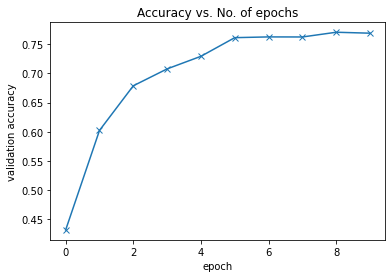

In [45]:
plot_accuracies(history)

Modelimiz% 75 civarında bir doğruluğa ulaşıyor ve grafiğe bakıldığında, modelin uzun bir süre eğitimden sonra bile% 80'den daha yüksek bir doğruluğa ulaşması pek olası görünmüyor. Bu, görüntüler ve etiketler arasındaki ilişkiyi daha doğru bir şekilde yakalamak için daha güçlü bir model kullanmamız gerekebileceğini gösteriyor. Bu, modelimize daha fazla evrişimli katman ekleyerek veya no. Her evrişimli katmandaki kanalların veya düzenlileştirme tekniklerinin kullanılmasıyla.


In [46]:
def plot_losses(history):
    train_loss = [x['train_loss'] for x in history]
    validation_loss = [x['val_loss'] for x in history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')#red ve o noktalara x işareti
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

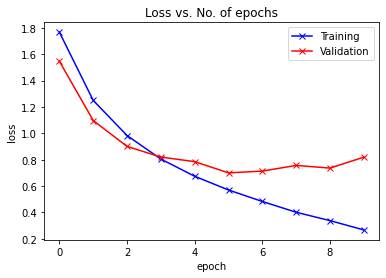

In [47]:
plot_losses(history)

Başlangıçta, hem eğitim hem de doğrulama kayıpları zamanla azalmış gibi görünüyor. Bununla birlikte, modeli yeterince uzun süre eğitirseniz, train kaybının azalmaya devam ettiğini, doğrulama kaybının azaldığını ve hatta belirli bir noktadan sonra artmaya başladığını fark edeceksiniz! bunada overfitting denir

Bu fenomene aşırı uyum denir ve hayırdır. 1 Neden birçok makine öğrenimi modeli gerçek dünya verileri üzerinde oldukça korkunç sonuçlar veriyor. Bunun nedeni, modelin kaybı en aza indirmek amacıyla, kalıpların eğitim verilerine özgü olduğunu öğrenmeye başlaması, hatta bazen belirli eğitim örneklerini ezberlemesidir. Bu nedenle, model daha önce görülmemiş verilere iyi bir şekilde genellemez.

overfittingde kaçınmak için bazı yaygın stratejiler şunlardır:

-Daha fazla eğitim verisi toplamak ve oluşturmak veya buna gürültü eklemek

-Toplu normalleştirme ve dropout gibi düzenleme tekniklerini kullanma

-validation kaybı artmaya başladığında model eğitiminin erken durdurulması


Bu dizideki bir sonraki eğitimde bu konuları daha ayrıntılı olarak ele alacağız ve modelimizde küçük ama önemli değişiklikler yaparak% 90'ın üzerinde bir doğruluğa nasıl ulaşabileceğimizi öğreneceğiz.

In [52]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': 10,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


## Testing with individual images


Şimdiye kadar bir modelin genel doğruluğunu takip ederken, bazı örnek görüntülerde modelin sonuçlarına bakmak da iyi bir fikirdir. Modelimizi 10000 görsellik önceden tanımlanmış test veri kümesinden bazı görüntülerle test edelim. ImageFolder sınıfını kullanarak bir test veri kümesi oluşturarak başlıyoruz.

In [56]:
test_dataset = ImageFolder(data_dir + '/test', transform = ToTensor())

In [71]:
def prediction_image(img, model):
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    _, pred = torch.max(y, dim = 1)
    return dataset.classes[pred.item()]

Predicted: airplane Label: airplane


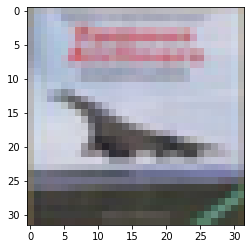

In [80]:
img, label = test_dataset[0]
print("Predicted:", prediction_image(img, model), "Label:", dataset.classes[label])
plt.imshow(img.permute(1,2,0));

Predicted: automobile Label: automobile


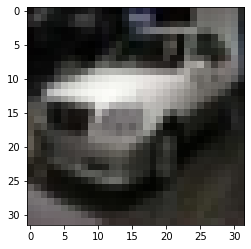

In [84]:
img, label = test_dataset[1546]
print("Predicted:", prediction_image(img, model), "Label:", dataset.classes[label])
plt.imshow(img.permute(1,2,0));

Predicted: ship Label: airplane


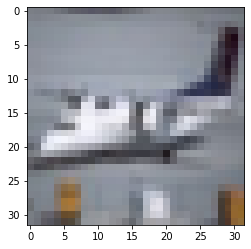

In [85]:
img, label = test_dataset[512]
print("Predicted:", prediction_image(img, model), "Label:", dataset.classes[label])
plt.imshow(img.permute(1,2,0));


Modelimizin nerede kötü performans gösterdiğini belirlemek, daha fazla eğitim verisi toplayarak, modelin karmaşıklığını artırarak / azaltarak ve hipeparametreleri değiştirerek modeli geliştirmemize yardımcı olabilir.

Son adım olarak, test setinde modelin genel kaybına ve doğruluğuna da bakalım ve jovian kullanarak kayıt yapalım. Bu değerlerin doğrulama seti için olanlara benzer olmasını bekliyoruz. Değilse, test seti ile benzer veri ve dağılıma sahip (genellikle gerçek dünya verilerinden gelen) daha iyi bir doğrulama setine ihtiyacımız olabilir.

özet olarak validation ile test değerleri benzer olmalı validation yüksekse overfitting olmuştur

In [87]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size = 2 * batch_size), device)

In [89]:
for img, lbl in test_dl:
    print(img.shape)
    print(lbl)
    break

torch.Size([256, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [90]:
test_result = evaluate(model, test_dl)

In [92]:
test_result # validation ile test değerleri birbirine yakın

{'val_acc': 0.7720702886581421, 'val_loss': 0.8293205499649048}

In [93]:
jovian.log_metrics(
        test_loss = test_result['val_loss'],
        test_acc =  test_result['val_acc']
)

[jovian] Metrics logged.


Modelimizi uzun süre eğittiğimiz ve yankılanabilir bir doğruluk elde ettiğimiz için, modeli daha sonra yeniden kullanabilmemiz ve sıfırdan yeniden eğitimden kaçınabilmemiz için modelin ağırlıklarını diske kaydetmek iyi bir fikir olacaktır. Modeli nasıl kaydedebileceğiniz aşağıda açıklanmıştır.

In [96]:
torch.save(model.state_dict(),'cifar10-cnn.pth')#state_dict() ile değerlerimizi alrız

.State_dict yöntemi, modelin doğru özniteliklerine eşlenen tüm ağırlıkları ve sapma matrislerini içeren bir OrderedDict döndürür. Model ağırlıklarını yüklemek için modeli aynı yapıyla yeniden tanımlayabilir ve .load_state_dict yöntemini kullanabiliriz.

In [98]:
model2 = to_device(Cifar10CnnModel(), device)

In [99]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [94]:
import jovian
jovian.commit(project='05-cifar10-cnn', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "tolgaisikp/05-cifar10-cnn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tolgaisikp/05-cifar10-cnn


'https://jovian.ai/tolgaisikp/05-cifar10-cnn'

In [ ]:
img, lbl = dataset[15151]
img.unsqueeze(0)

In [ ]:
model(img.unsqueeze(0))

In [ ]:
_, preds = torch.max(model(img.unsqueeze(0)), dim = 1)
preds

In [ ]:
print(dataset.classes[preds.item()])
lbl

In [ ]:
arr=[5,1,6,4,5]

In [ ]:
a = 0
tt = []

In [ ]:
len(arr)-2

In [ ]:
len(arr)-2

In [ ]:

while True:
    t = 0
    for i in range(len(arr)-1):
        if(a < (len(arr) - 2)):
            break  
        else:
            t+=arr[i+a]
            print(arr[i+a])
            
    a+=1
    print("a")
    if t==0:
        break
    else:
        tt.append(t)
    

  

In [ ]:
tt

In [ ]:
torch.cuda.empty_cache()
